In [5]:
#!pip install pandas matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal, shapiro
#!pip install scikit-posthocs
import scikit_posthocs as sp
import numpy as np

In [6]:
# Leitura dos dados
df = pd.read_csv('mosdepth.tsv', sep='\t')
df.head()

,Fracionamento,Réplica,Tempo(s),Memória(MB),Disco(MB),CPU(%),Rede(MB)
0,5%,1,30.09,1963.11,5676.86,8.07,88.52
1,5%,2,29.08,1994.24,5680.06,8.29,88.52
2,5%,3,29.08,1988.70,5680.13,8.32,88.52
3,5%,4,29.08,1945.71,5680.19,8.23,88.52
4,5%,5,29.11,1992.17,5680.22,8.33,88.52


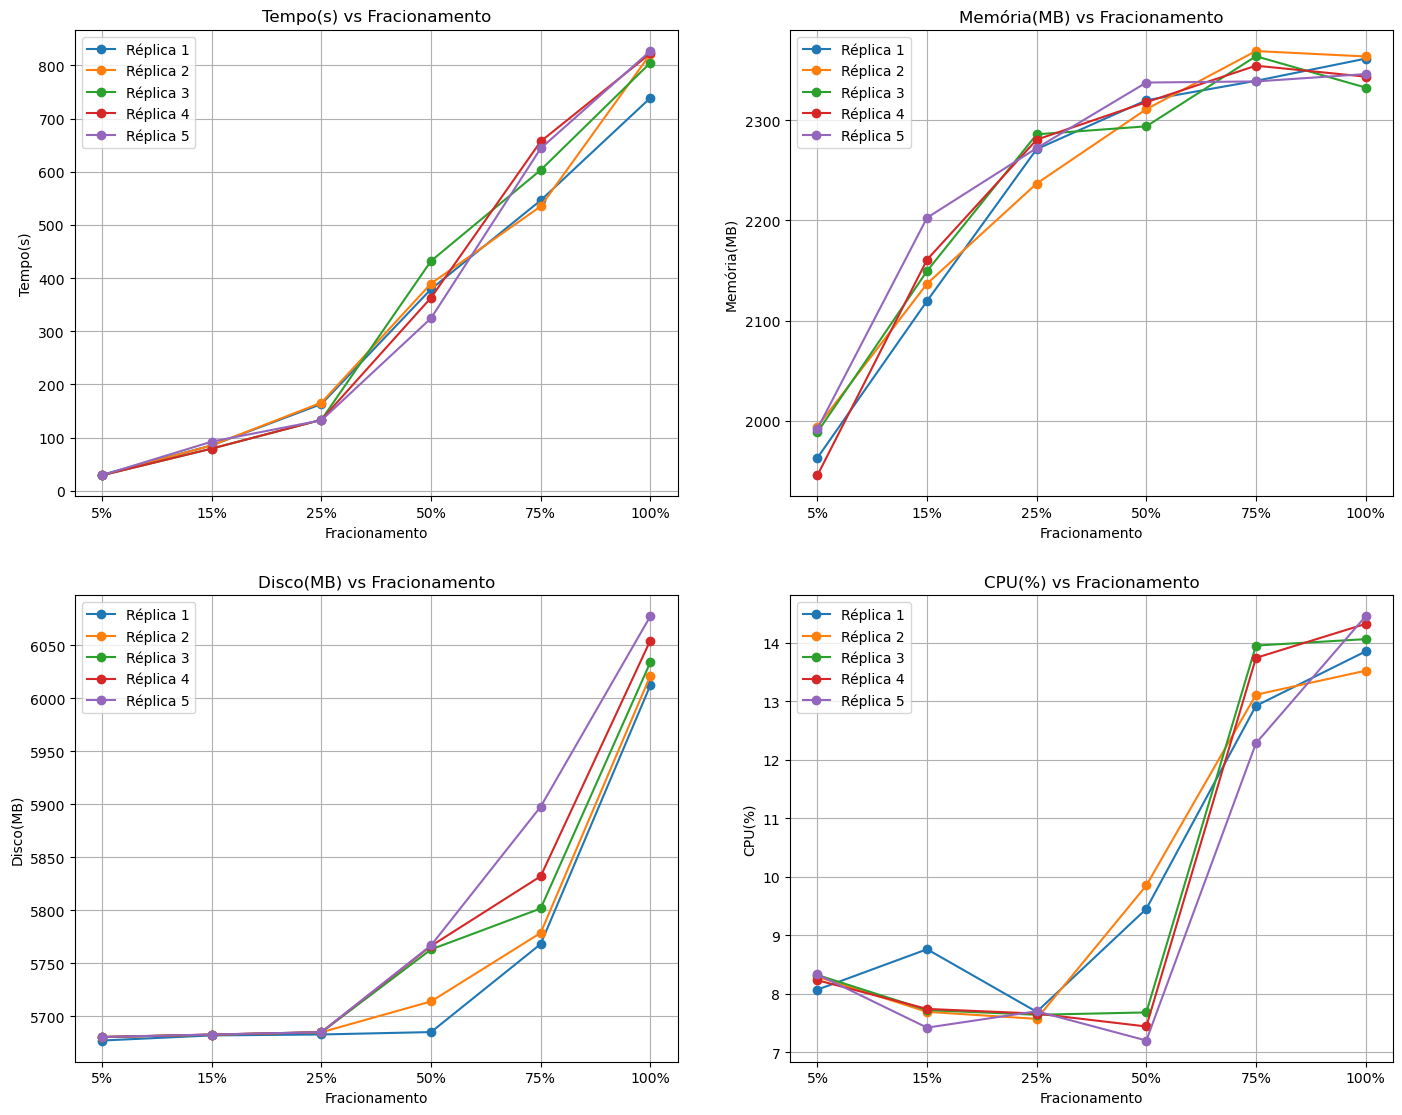

In [ ]:
metrics = ['Tempo(s)','Memória(MB)','Disco(MB)','CPU(%)']
fracs = df['Fracionamento'].unique()

# Atualizar os gráficos com as réplicas como linhas, organizados em 2 colunas
fig, axs = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=(15, 12))
fig.tight_layout(pad=5.0)

axs = axs.flatten()

for i, metric in enumerate(metrics):
    for replica in df['Réplica'].unique():
        replica_data = df[df['Réplica'] == replica]
        axs[i].plot(
            replica_data["Fracionamento"],
            replica_data[metric],
            marker='o',
            label=f"Réplica {replica}"
        )
    axs[i].set_title(f"{metric} vs Fracionamento")
    axs[i].set_xlabel("Fracionamento")
    axs[i].set_ylabel(metric)
    axs[i].grid(True)
    axs[i].legend()

# Remover eixos extras, caso o número de gráficos seja menor que o número de subplots criados
for j in range(len(metrics), len(axs)):
    fig.delaxes(axs[-1])

plt.show()


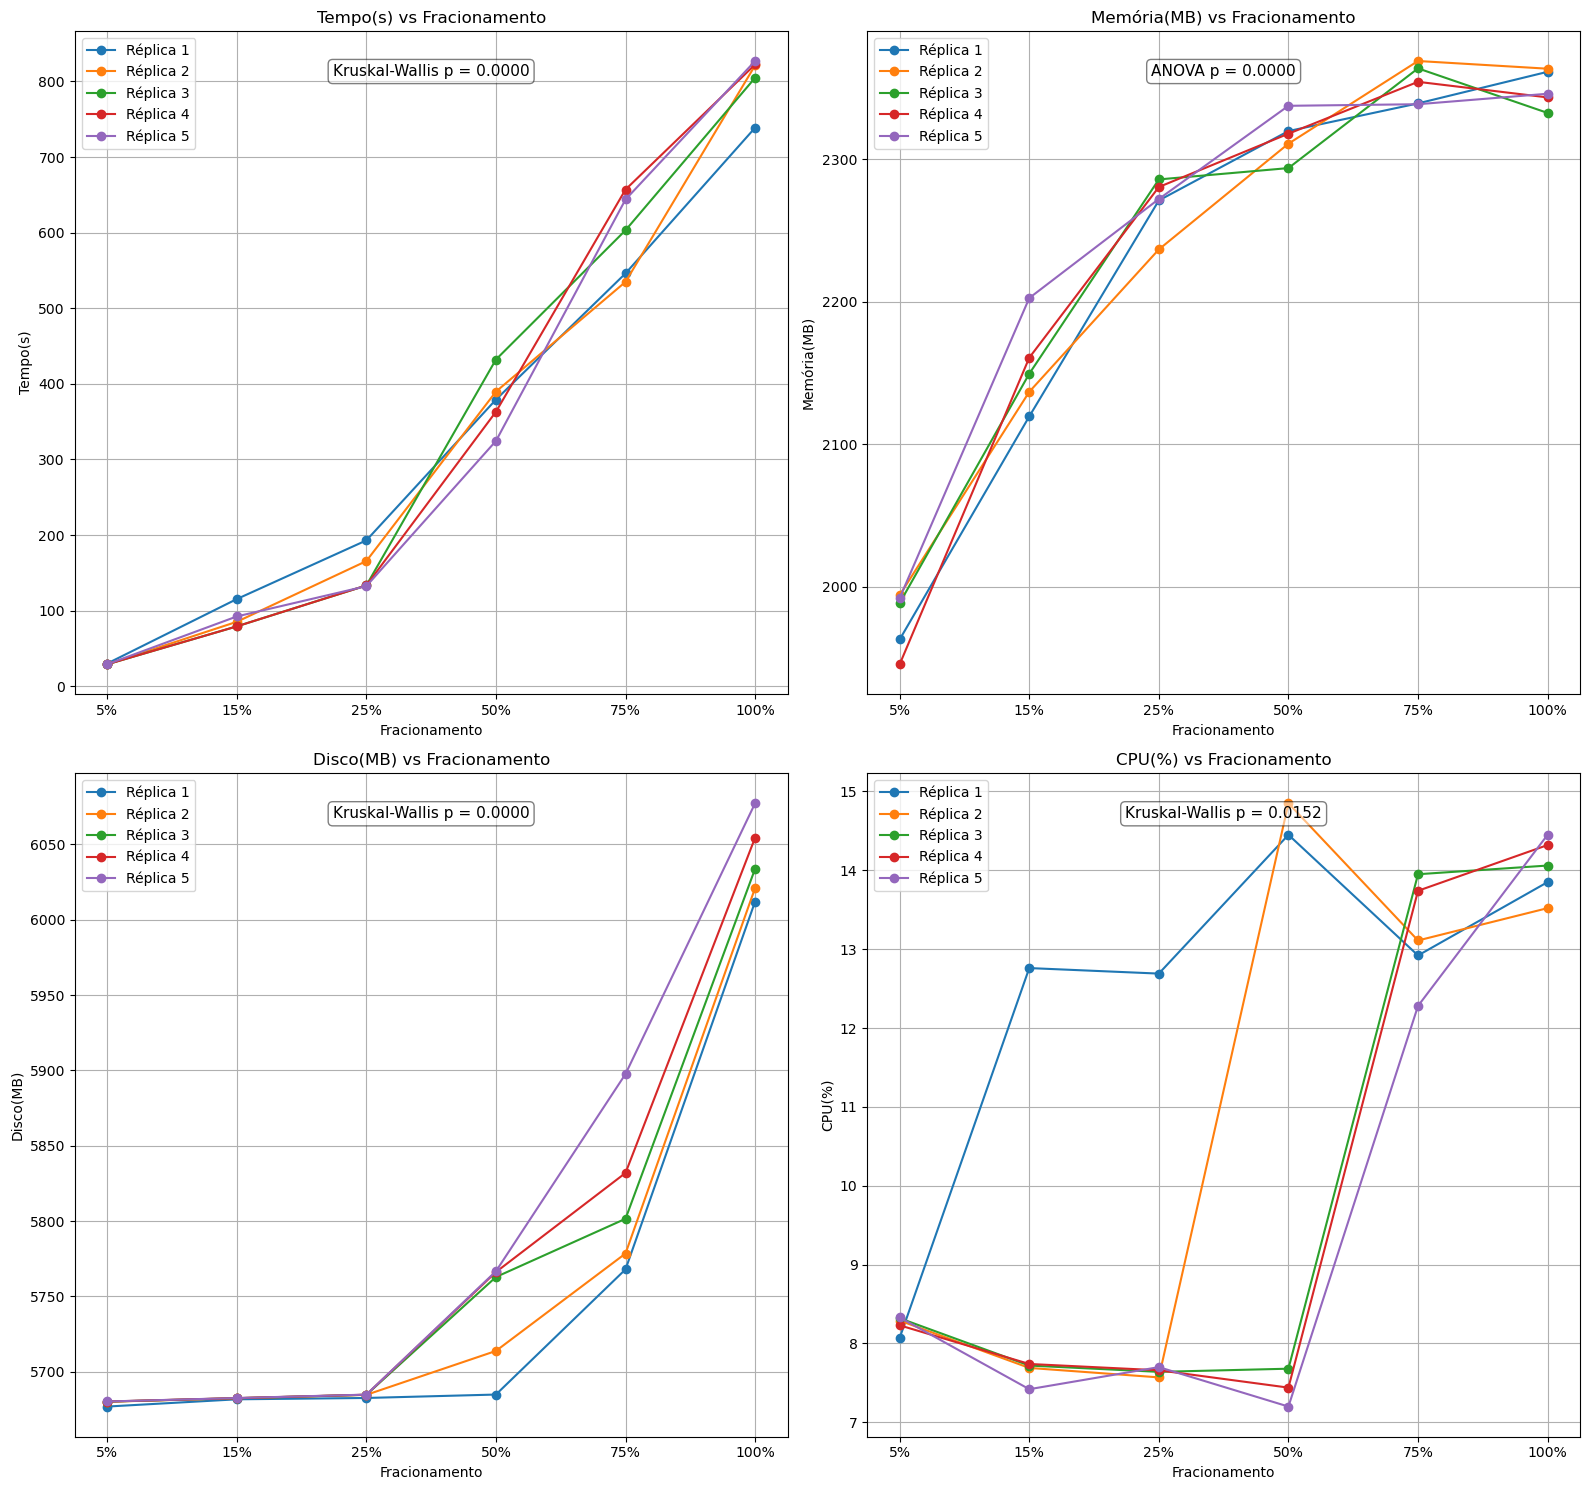

In [ ]:
metrics = ['Tempo(s)','Memória(MB)','Disco(MB)','CPU(%)']
fracs = df['Fracionamento'].unique()

fig, axs = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=(16, 5 * (len(metrics) // 2 + 1)))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]

    # Gráfico de linha por réplica
    for replica in df['Réplica'].unique():
        replica_data = df[df['Réplica'] == replica]
        ax.plot(replica_data["Fracionamento"], replica_data[metric], marker='o', label=f"Réplica {replica}")

    # Boxplot ao fundo com seaborn (opcional, remove se ficar poluído)
    #sns.boxplot(x='Fracionamento', y=metric, data=df, ax=ax, whis=1.5, showcaps=False, boxprops=dict(alpha=0.3))

    ax.set_title(f"{metric} vs Fracionamento")
    ax.set_xlabel("Fracionamento")
    ax.set_ylabel(metric)
    ax.grid(True)

    # Teste estatístico (ANOVA se normal, senão Kruskal-Wallis)
    groups = [df[df['Fracionamento'] == f][metric] for f in fracs]
    
    # Teste de normalidade para cada grupo
    normal = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
    
    if normal:
        stat, pval = f_oneway(*groups)
        test_name = "ANOVA"
    else:
        stat, pval = kruskal(*groups)
        test_name = "Kruskal-Wallis"
    
    ax.text(0.5, 0.95, f"{test_name} p = {pval:.4f}", transform=ax.transAxes,
            fontsize=11, verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.legend()

# Remove gráfico extra se número de métricas for ímpar
if len(metrics) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

In [ ]:

for metric in metrics:
    print(f"\n🔎 Analisando: {metric}")
    
    # Separar os dados por fracionamento
    groups = [df[df['Fracionamento'] == frac][metric] for frac in df['Fracionamento'].unique()]
    
    # Kruskal-Wallis
    stat, p = kruskal(*groups)
    print(f"  ➤ Kruskal-Wallis p-valor = {p:.5f}")
    
    if p < 0.05:
        print("  ➤ Diferença significativa detectada. Executando Dunn's test...")
        
        # Teste de Dunn com correção de Bonferroni
        dunn = sp.posthoc_dunn(df, val_col=metric, group_col='Fracionamento', p_adjust='bonferroni')
        
        # Mostrar apenas os pares com significância estatística
        sig_pairs = []
        for i in dunn.index:
            for j in dunn.columns:
                if i < j and dunn.loc[i, j] < 0.05:
                    sig_pairs.append((i, j, dunn.loc[i, j]))

        if sig_pairs:
            for a, b, pval in sig_pairs:
                print(f"    • Diferença significativa entre {a} e {b} (p = {pval:.5f})")
        else:
            print("    • Nenhum par significativo detectado após correção.")
    else:
        print("  ➤ Nenhuma diferença estatisticamente significativa.")


🔎 Analisando: Tempo(s)
  ➤ Kruskal-Wallis p-valor = 0.00003
  ➤ Diferença significativa detectada. Executando Dunn's test...
    • Diferença significativa entre 100% e 15% (p = 0.00488)
    • Diferença significativa entre 100% e 5% (p = 0.00011)
    • Diferença significativa entre 5% e 75% (p = 0.00488)

🔎 Analisando: Memória(MB)
  ➤ Kruskal-Wallis p-valor = 0.00005
  ➤ Diferença significativa detectada. Executando Dunn's test...
    • Diferença significativa entre 100% e 15% (p = 0.03825)
    • Diferença significativa entre 100% e 5% (p = 0.00135)
    • Diferença significativa entre 15% e 75% (p = 0.01838)
    • Diferença significativa entre 5% e 75% (p = 0.00054)

🔎 Analisando: Disco(MB)
  ➤ Kruskal-Wallis p-valor = 0.00003
  ➤ Diferença significativa detectada. Executando Dunn's test...
    • Diferença significativa entre 100% e 15% (p = 0.00492)
    • Diferença significativa entre 100% e 5% (p = 0.00011)
    • Diferença significativa entre 5% e 75% (p = 0.00492)

🔎 Analisando: CPU